In [62]:
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2
from scripts.parsing_utils import *
from utils.utils import *
from scripts.parse_results import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
RES_DIR = "/flash1/pari/VLDB-Nov1-Results/all_results/vldb/test_diff/mscn/lc/"

In [64]:
all_df2 = get_all_training_df(RES_DIR)

In [65]:
def update_alg_name(df, cols):
    df['alg'] = df[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

COLS = ["loss_func"]
COLORS = ["cyan", "green", "orange", "red", "black", "violet", "lightblue", "gray"]


SAVE_DIR ="./figures/results1_lc/"
make_dir(SAVE_DIR)
FN_TMP = "{ERROR_TYPE}-{SAMPLES_TYPE}-{PART}.png"

COLORS = {}
COLORS["Flow Loss"] = "blue"
COLORS["Flow Loss Bitmap"] = "lightblue"

COLORS["Q-Error"] = "green"
COLORS["Q-Error Bitmap"] = "lightgreen"

LINESTYLES = {}
LINESTYLES["Flow Loss"] = ":"
LINESTYLES["Q-Error"] = "--"

LINESTYLES["Flow Loss Bitmap"] =  (0, (3, 10, 1, 10))
LINESTYLES["Q-Error Bitmap"] = (0, (3, 10, 1, 10))

ALG_KEY = {}
ALG_KEY["flow_loss2"] = "Flow Loss"
ALG_KEY["flow_loss2_bitmap"] = "Flow Loss Bitmap"

ALG_KEY["mse"] = "Q-Error"
ALG_KEY["mse_bitmap"] = "Q-Error Bitmap"

ERR_KEYS = {}
ERR_KEYS["jerr"] = "Postgres Plan Error"
ERR_KEYS["mm1_plan_err"] = "Simple Plan Error"
ERR_KEYS["inl_jerr"] = "Postgres INL Plan Error"

ERR_KEYS["qerr"] = "Log Normalized Q-Error"
ERR_KEYS["flow_err"] = "Flow Error"

TITLE_KEYS = {}
TITLE_KEYS["test"] = "Test Set"
TITLE_KEYS["train"] = "Train Set"

In [66]:
# apply all the filter conditions
all_df2.keys()
try:
    all_df2["cost_model"] = all_df2["cost_model"].apply(lambda row: COST_MODEL_NAMES[row])
except:
    pass
update_alg_name(all_df2, COLS)

# if COST_MODEL is not None:
#     all_df2 = all_df2[all_df2["cost_model"] == COST_MODEL]
    
# if MAX_EPOCH is not None:
#     all_df2 = all_df2[all_df2["epoch"] <= max_epoch]
# if HLS is not None:
#     all_df2 = all_df2[all_df2["hidden_layer_size"] == HLS]
    
# HUE_COLORS = {}
# algs = list(set(all_df2["alg_name"]))
# algs.sort()
# for i,alg in enumerate(algs):
#     HUE_COLORS[alg] = COLORS[i]
        
# print(HUE_COLORS)

In [67]:
df = all_df2[all_df2["template"] == "all"]
df = df[df["num_tables"] == "all"]
df = df[df["summary_type"] == "mean"]
#df = df[df["epoch"] > 1]

#all_df = all_df2[all_df2["template"] != "all"]
#all_df = all_df[all_df["summary_type"] == "mean"]

In [68]:

def plot_learning_curve(df, loss_type, samples_type, part):
    fn = FN_TMP.format(ERROR_TYPE = loss_type,
                       SAMPLES_TYPE = samples_type,
                        PART = part)
    fn = SAVE_DIR + fn
    
    plt.style.use('ggplot')   
    plt.figure(figsize=(5,4))
    plt.title(ERR_KEYS[loss_type] + " (" + TITLE_KEYS[samples_type] + ")")

    
    df = df[df.samples_type == samples_type]
    #df = df[df.partition == part]
    df = df[df.loss_type == loss_type]
    algs = set(df["alg"])
    
#     for alg in algs:
#         tmp_df = df[df.alg == alg]     
#         alg_label = ALG_KEY[alg]

#         y = tmp_df["loss"].values
#         x = tmp_df["epoch"].values
#         plt.plot(x, y, label = alg_label, linestyle=LINESTYLES[alg_label], linewidth=3, color = COLORS[alg_label])
        
#         plt.yscale("log")
#         plt.legend(frameon=False)
    
    sns.lineplot(data=df, hue="alg", x="epoch", y="loss")
    plt.yscale("log")
    #plt.ylim(None,2e6)
    #plt.xticks(range(2,20,2))
    plt.savefig(fn)
    plt.show()

2


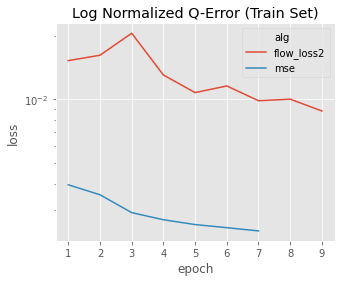

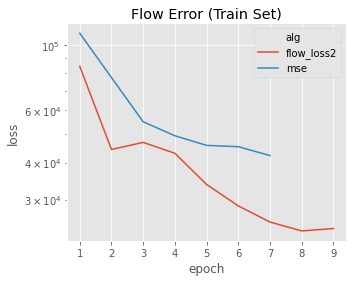

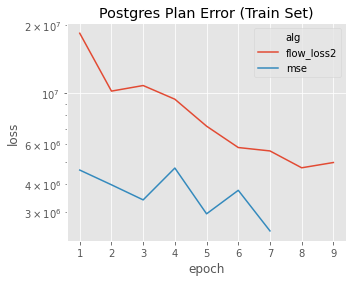

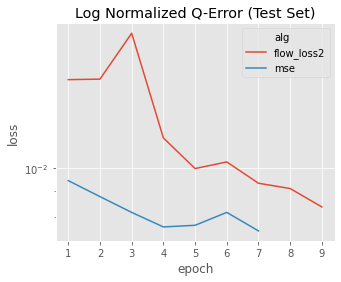

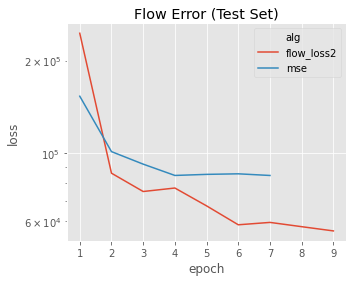

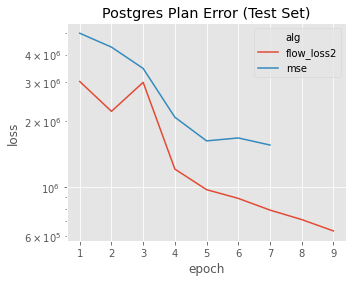

7


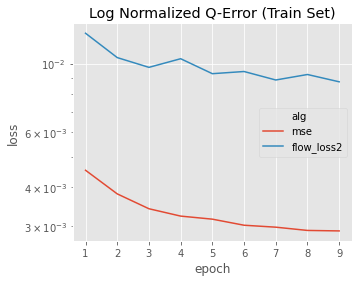

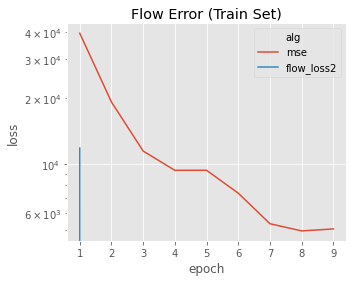

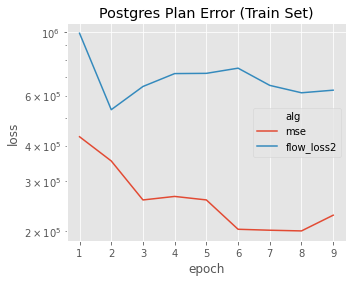

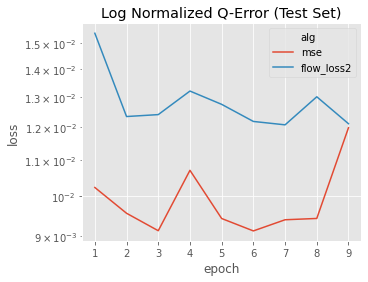

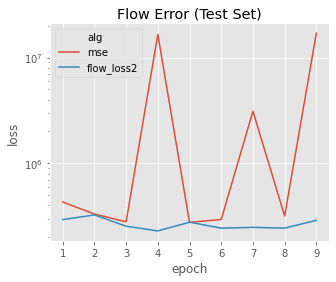

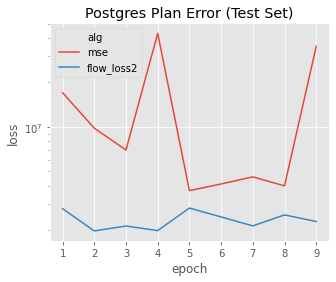

In [69]:
STS = ["train", "test"]
LTS = ["qerr", "flow_err", "jerr"]

for part in set(df["partition"]):
    print(part)
    tmp_df = df[df.partition == part]
    for st in STS:
        for lt in LTS:
            plot_learning_curve(tmp_df, lt, st, "all")

In [160]:
PARTITION = 7
cur_df = df[df.partition == PARTITION]
cur_df["Loss Function"] = cur_df.apply(lambda x: ALG_KEY[x["alg"]] ,axis=1)
print(set(cur_df["Loss Function"]))

{'Flow Loss', 'Q-Error'}


<ipython-input-160-ffba7f0ec58d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_df["Loss Function"] = cur_df.apply(lambda x: ALG_KEY[x["alg"]] ,axis=1)


In [157]:
def plot_one_ax(df, err_type, yscale, ylabel, ax, title=None,legend=False):
    df = df[df.loss_type == err_type]
    maxy = max(df["loss"])
    df = df[["Loss Function", "epoch", "loss"]]
    # add epoch 0 as 2x the max
    ep0_loss = 3*maxy
    loss_funcs = set(df["Loss Function"])
    ep0_dict = defaultdict(list)
    for lf in loss_funcs:
        ep0_dict["epoch"].append(0)
        ep0_dict["loss"].append(ep0_loss)
        ep0_dict["Loss Function"].append(lf)
    ep0_df = pd.DataFrame(ep0_dict)
    df = pd.concat([ep0_df, df], ignore_index=True)
    
    sns.lineplot(data=df, hue="Loss Function", x="epoch", y="loss", palette=COLORS, ax=ax, style="Loss Function")
    #sns.lineplot(data=df, hue="Loss Function", x="epoch", y="loss", palette=COLORS, ax=ax)

    ax.set_yscale(yscale)
    ax.set_ylim((None,maxy))
    ax.set_ylabel(ylabel)
    ax.legend().remove()
    
    if title is not None:
        ax.set_title(title, fontsize=20)
    
    if legend:
        ax.legend(loc="upper left", bbox_to_anchor=(0.00, 1.20), ncol=1)

./figures/results1_lc/learning-curves-part-7.png


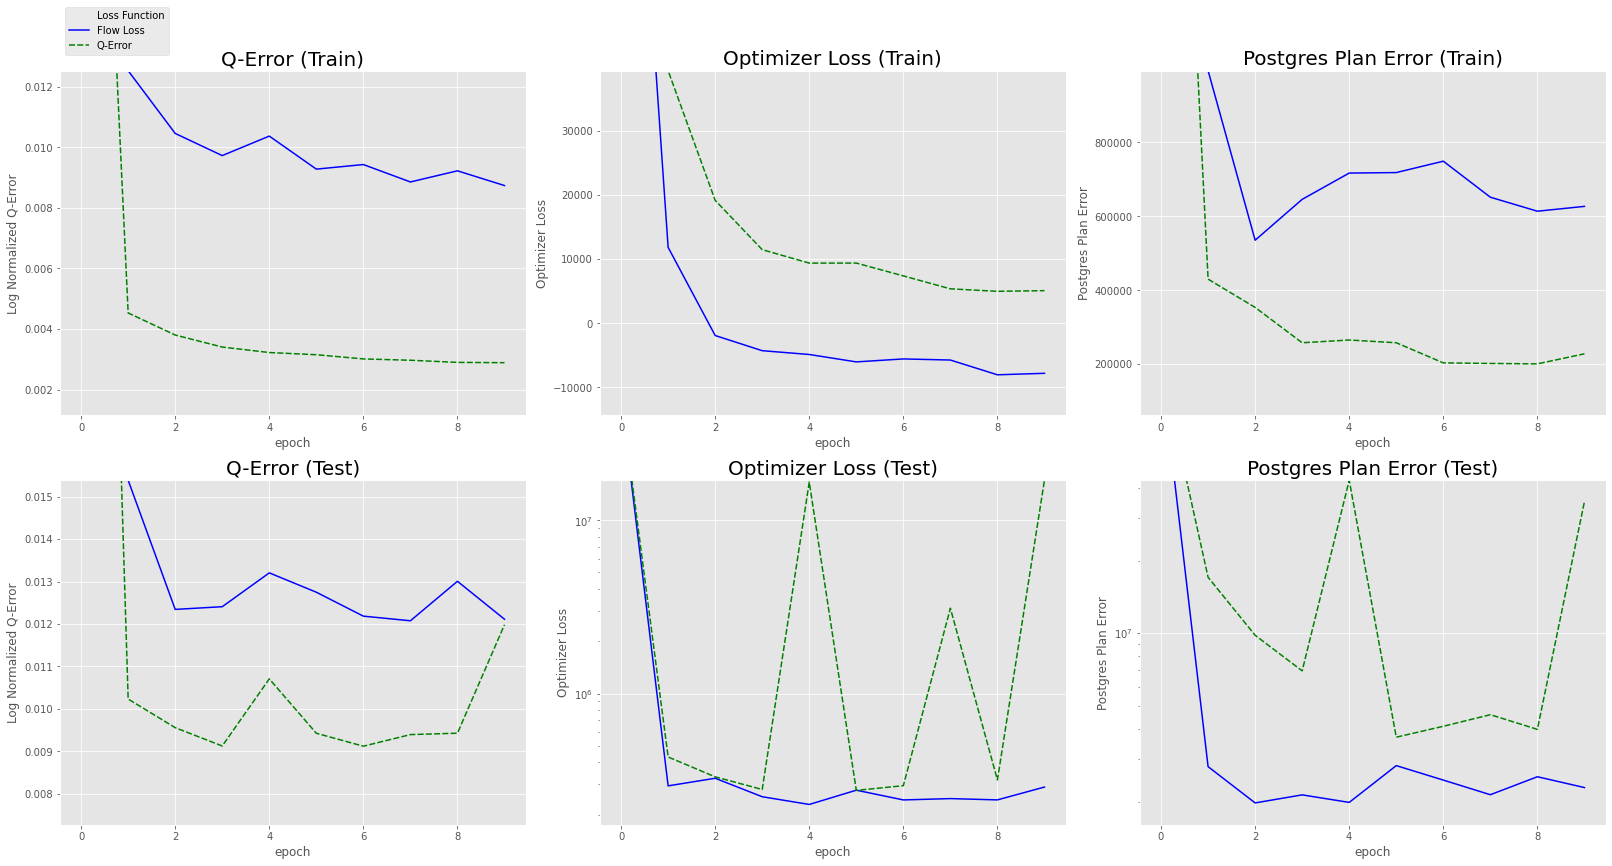

In [162]:
plt.style.use('ggplot')
fig, axs = plt.subplots(figsize=(22.5,12), nrows=2, ncols=3)

train_df = cur_df[cur_df.samples_type == "train"]

plot_one_ax(train_df, "qerr", "linear", "Log Normalized Q-Error", axs[0, 0], legend=True, title="Q-Error (Train)")
plot_one_ax(train_df, "flow_err", "linear", "Optimizer Loss", axs[0, 1], title="Optimizer Loss (Train)")
plot_one_ax(train_df, "jerr", "linear", "Postgres Plan Error", axs[0, 2], title="Postgres Plan Error (Train)")


test_df = cur_df[cur_df.samples_type == "test"]
plot_one_ax(test_df, "qerr", "linear", "Log Normalized Q-Error", axs[1, 0], title="Q-Error (Test)")
plot_one_ax(test_df, "flow_err", "log", "Optimizer Loss", axs[1, 1], title="Optimizer Loss (Test)")
plot_one_ax(test_df, "jerr", "log", "Postgres Plan Error", axs[1, 2], title="Postgres Plan Error (Test)")

fig.tight_layout(h_pad=1, w_pad=1.0)

fn = "learning-curves-part-" + str(PARTITION) + ".png"
fn = SAVE_DIR + fn
print(fn)
plt.savefig(fn, bbox_inches="tight")
plt.show()

In [84]:
axs.shape

(2, 3)

In [74]:
print(set(cur_df["Loss Function"]))

{'Flow Loss', 'Q-Error'}
